# Data Science Workshop: Final Project
## KKBox Churn Prediction Challenge
## By Yaniv Bar-Lev and Shahar Linial

### Objective: we will try to predict whether a user will churn ending its current subscription.

### Motivation: KKBOX is Asia’s leading music streaming service, holding the world’s most comprehensive Asia-Pop music library with over 30 million tracks. They offer a generous, unlimited version of their service to millions of people, supported by advertising and paid subscriptions. This delicate model is dependent on accurately predicting churn of their paid users.

### Data source: [8GB - Kaggle Challenge: WSDM - KKBox's Churn Prediction Challenge](https://www.kaggle.com/c/kkbox-churn-prediction-challenge/data)
### [GitHub: Source Code for Reproduction Purposes](https://github.com/shaharlinial/kkbox-challenge)

### Definitions: 
#### 1. Churn: a user is defined as churned if he had not done any transaction during the 30-days period after his subscription has ended. 

*An example: Let's say we have a user whose subscription is ending at **31.12.2018**, if the user shall not make any transaction untill the **31.01.2019**, it will be defined as **churned** from that day onwards.*

*Churn value is not given, hence, it has to be extracted out of the dataset*

#### 2. msno: A user's unique id.
#### 3. Panel: A data structure that contains only users who had their subscription expired anytime between a given timestamp and 31 days that had preceeded that timestamp. As well each user in the panel contains general , activity and transactions information for a period of 31 days before and after it's expiration.

*A panel is needed in order to distinguish between users that have churned and users that haven't, we will feed our model with these panels as training and validating datasets.*

*We will create different panels, in different timestamps in order to train and evaluate our models.*

### Methodology:
#### Step 1:  Data Analysis: We will start off by prevewing the data and creating histograms in order to understand on which time period shall be the most suitable for the model.
#### Step 2: Setting up 4 different timestamps for 4 panel creations.
#### Step 3: Panel creation *Iterative Step*:
* Data preprocessing:
* * Relevant *member* extraction, data cleaning, dimension reduction
* * Relevant *transaction* extraction, data cleaning, dimension reduction
* Panel Creation:
* * Setting up data for training/validation, setting up user's churn values.
* Feature Engineering
* * Features from transactions,members and user logs
* Label generation
* Data Cleanup
* Saving Data for aggregation


#### Step 4: Modeling and Classification:
* Data concatentation for all different panels.
* Data split for train/test sets.
* Learning Models and Analysis with:
* * Logistic Regression
* * Decision Tree
* * Random Forest
* * Neural Network
* * XGBoost
* Results Comparison on Test Set
* Dimension Reduction
* Model Calibration with Grid Search

#### Step 5: Model Evaluation on validation set
* Evaluating the performance of our model on the validation set and comparing naive model vs the optimized one


#### Step 6: Conclusion - Business case scenario
* Presenting a business case to showcase how this model can be put to action and how to maximize its potentialprofits 

# Step 0: Imports, Data Loading, Run-Once

*Run this if you don't have scikit-plot installed in jupyter environment*

In [180]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install scikit-plot xgboost imblearn

    100% |████████████████████████████████| 174kB 851kB/s ta 0:00:01
imbalanced-learn 0.5.0 has requirement scikit-learn>=0.21, but you'll have scikit-learn 0.20.1 which is incompatible.


*Imports and run-once:*

In [2]:
import glob
import pandas as pd
import numpy as np
import pickle as pk
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import sklearn as sk
import time
from sklearn.model_selection import train_test_split
import scikitplot as skplt
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import math
from tqdm import tqdm_notebook

In [194]:
pd.set_option('display.max_columns', 100)
members = pd.read_csv('dataset/members_v3.csv')
transactions = pd.read_csv('dataset/transactions.csv')


### Loading Log files
#### Due to the size of the log files (over 22GB/ 400 Million rows) we were forced to upload the data using chunks, hence we will be loading only the necessary data using the current members examined with the following function.

In [2]:
def retrieve_logs(X): 
    log_trimmed = pd.DataFrame()
    for gm_chunk in pd.read_csv(r'dataset/user_logs.csv',chunksize=10000000):
        log_trimmed = pd.concat([log_trimmed,gm_chunk[gm_chunk.msno.isin(X.index)]])
    return log_trimmed    

# Step 1: Data Analysis

### Members Dataset:

| Property               | Description                  |
|------------------------|------------------------------|
| msno                   | User identifier              |
| city                   | City of user, numeric        |
| bd                     | Age                          |
| gender                 |                              |
| registered_via         | registration method, numeric |
| registration_init_time | format %Y%m%d                |
| expiration_date        | format %Y%m%d                |

We will start off by previewing the **_members_ histogram** showing count over registration time (years)

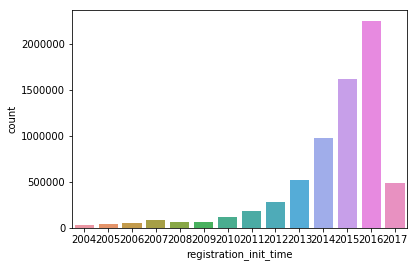

In [195]:
#Registrations over time
members.registration_init_time= pd.to_datetime(members.registration_init_time, format='%Y%m%d')
sns.countplot(members.registration_init_time.apply(lambda x: x.year) ) 

We can see that around 2016, most users had registered to the app,
so we will focus on data extraction over that period.

Another reason focusing on newer data:


Speaking of techonology usage, specifically application usage, the newer the data, more relevant it is.

### Transactions dataset

| Property               | Description                                                          |
|------------------------|----------------------------------------------------------------------|
| msno                   | User identifier                                                      |
| payment_method_id      | payment method, numeric                                              |
| payment_plan_days      | length of membership plan in days                                    |
| plan_list_price        | in New Taiwan Dollar (NTD)                                           |
| actual_amount_paid     | in New Taiwan Dollar (NTD)                                           |
| is_auto_renew          |                                                                      |
| transaction_date       | format %Y%m%d                                                        |
| membership_expire_date | format %Y%m%d                                                        |
| is_cancel              | whether or not the user canceled the membership in this transaction. |

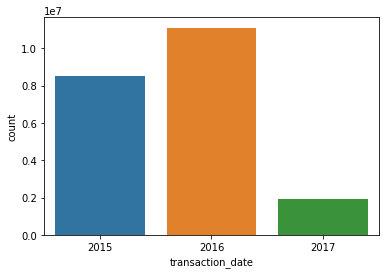

In [196]:
#Transactions by year
sns.countplot(transactions.transaction_date.apply(lambda x: int(x/10000)))

We can see that around 2016, most users had done transactions within the app.


Thus, alongside the members histogram, **we are aiming to train our model over newer time periods, to assure more relevant and accurate prediction model.**

### User Logs dataset
#### Includes the activity on the app itself. Logs are recorded on a daily basis.

| Property   | Description                                                |
|------------|------------------------------------------------------------|
| msno       | User identifier                                            |
| date       | Log date (format: %Y%m%d)                                  |
| num_25     | # of songs played less than 25% of the song length         |
| num_50     | # of songs played between 25% to 50% of the song length    |
| num_75     | # of songs played between 50% to 75% of of the song length |
| num_985    | # of songs played between 75% to 98.5% of the song length  |
| num_100    | # of songs played over 98.5% of the song length            |
| num_unq    | # of unique songs played                                   |
| total_secs | total seconds played                                       |

# Step 2: Setting up 4 timestamps for 4 panel creation. 
####  To create a large panel we will gather a few panels of users based on their expiration date on several window time frames. According the histograms above we decide that the cutoff dates we will use:

*This means that the panel creation code and the feature engineering part will be executed 4 times, each with a different cutoff date as listed above.*

| Date       | Purpose    | Timestamp |
|------------|------------|-----------|
| 28/01/2017 | Validation | 20170128  |
| 16/12/2016 | Test       |  20161216 |
| 26/11/2016 | Test       |  20161126 |
| 25/10/2016 | Test       |  20161025 |
| 23/09/2016 | Test       | 20160923  |

In [4]:
validations_timestamps = ['20170128']
test_timestamps = ['20161216','20161126','20161025','20160923']

# Step 3: Panel Creation *Iterative Step*

## Step 3.1: Data Preprocessing
### Function Definitions

#### Step 3.1.1 : *Extracting members from members.csv*

The following code is for extracting **all members from members.csv,
that had registered before the *timestamp* given.**

In [4]:
def extract_members_with_cutoff(members, timestamp):
    cutoff_date = pd.Timestamp(timestamp) 
    cutoff_date_start  =  cutoff_date - datetime.timedelta(days=31)
    cutoff_end_date =  cutoff_date + datetime.timedelta(days=31)
    #Reducing memory size by downgrading data types
    members['city'] = members['city'].apply(pd.to_numeric,downcast='unsigned') #data 0-22
    members['registered_via'] = members['registered_via'].apply(pd.to_numeric,downcast='signed')
    members.registration_init_time= pd.to_datetime(members.registration_init_time, format='%Y%m%d')
    
    # Number of lines is equal to number of rows which validates that all msno are unique.
    print("Number of unique msno's falling in criteria: %d" % len(set(members.msno)))
    #Removing out of sample data. Done for each cutoff point as described at the beginning
    return members[members.registration_init_time<cutoff_date]

#### Step 3.1.2: Transactions extraction out of transactions.csv

The following code is for extracting **all transactions from transactions.csv,
that had registered before the *timestamp* given.**

In [5]:
def extract_transactions_with_cutoff(transactions, members, timestamp):
        cutoff_date = pd.Timestamp(timestamp) 
        cutoff_date_start  =  cutoff_date - datetime.timedelta(days=31)
        cutoff_end_date =  cutoff_date + datetime.timedelta(days=31)
        trans = transactions
        #Change Format of date
        trans.transaction_date= pd.to_datetime(trans.transaction_date, format='%Y%m%d')
        trans.membership_expire_date= pd.to_datetime(trans.membership_expire_date, format='%Y%m%d')
        
        #Keep only rows of users who are in our members dataset
        trans_trimmed = trans[trans.msno.isin(members.msno)] 
        
        #remove out of sample data based on cutoff date
        return trans_trimmed[trans_trimmed.transaction_date<cutoff_date] 

#### Step 3.2: Panel creation out of members and transactions

The following code is for creating a panel that contains the latest log of all members for the 30 days prior to the given timestamp

In [6]:
def generate_panel_and_update_transactions(members_at_cutoff, transactions_at_cuttoff,timestamp):
        cutoff_date = pd.Timestamp(timestamp) 
        cutoff_date_start  =  cutoff_date - datetime.timedelta(days=31)
        cutoff_end_date =  cutoff_date + datetime.timedelta(days=31)
        trans_trimmed = transactions_at_cuttoff
        #"last_log" the last transaction made by the user before the cutoffdate. Will be used to calculate the 30 days churn window indicator.
        trans_trimmed = trans_trimmed.sort_values(by=['msno','transaction_date']) #Sort by msno and transaction_date
        
        last_log = trans_trimmed.groupby(['msno']).last()

        #panel will include only members whose last log was before the cutoff date and expiration is after the cutoff date start
        #Logic: We're looking for users whose membership expires 30 days before the cutoff point
        panel = pd.DataFrame((last_log[(last_log.membership_expire_date<cutoff_date) & ( last_log.membership_expire_date>=cutoff_date_start)]).index)
        #Keeping only the relevant members in the trans_trimmed table
        return panel, trans_trimmed[trans_trimmed.msno.isin(panel.msno)]

#### Some utility functions for use

In [7]:
def old_transaction_data(i,trans_2d):
    return trans_2d.iloc[i].msno, trans_2d.iloc[i].transaction_date, trans_2d.iloc[i].membership_expire_date

def new_transaction_date(i,trans_2d):
    return trans_2d.iloc[i].transaction_date, trans_2d.iloc[i].membership_expire_date
    
def weekday (x):
    return datetime.datetime.weekday(x) 

def remove_outliers(sr):    #removing outliers of a list using 3 std limit
    return abs(sr- sr.mean() < 3 * sr.std())

def categorizing(df,sr,name): #df, sr - sereis (df.sr), name = name of the new variable
    just_dummy = pd.get_dummies(sr)
    just_dummy= just_dummy.add_prefix(name +'_')
    df = df.join(just_dummy,how='left')
    df = df.drop(name,axis=1)
    return df

#### Step 3.3: Feature Engineering

We will generate the following features for the dataset we have.
It will require some data-manipulations. 

| Feature Name                              | Feature Description                          |
|-----------------                          |----------------------------------------------|
| msno                                      | unique user identifier                       |
| times_churn                               | number of times a user has churned           |
| join_date                                 | registration date from members table         |
| days                                      | Total Days on plan                           |
| city                                      | nominal,- dummy city_A,B,C                   |
| bd                                        | Age of user                                  |
| gender                                    | Gender                                       |
| registrated_via                           | how the user had registered                  |
| num_cancel                                | number of cancellations in transaction table |
| cnt_trans                                 | count of transactions                        |
| tot_price                                 | total list price                             |
| tot_paid                                  | total actual paid                            |
| ct_pmt                                    | count of actual payments                     |
| ct_plan30                                 | number of plans 0-30 days                    |
| ct_pln_ovr30                              | number of plans over 30                      |
| cnt_autorenew                             | num of autorenew                             |
| last_trans_weekday                        | the weekday of the last transaction          |
| can_ratio                                 | Cancelations out of total transactions       |
| plandays_max/min/mean/std                 | Descriptive statistics of # days of plans    |
| pmt_method_num                            | Number of unique payment methods             |
| pln_uniq                                  | Unique plan days                             |
| plan_list_price_max/min/mean/std          | plan list price statistics                   |
| actual_amount_paid_max/min/mea/std        | Actual amount paid stats                     |
| actual_amount_paid_cnt                    | Unique amount paid                           |
| auto_renew_cnt                            | Number of auto renewals                      |
| last_pmt_mtd                              | Last used payment method                     |
| last_pln_days                             | Number of days in last plan                  |
| last_plan_price                           | Price of last plan                           |
| last_paid                                 | Last payment                                 |
| last_auto_renew                           | Was last transaction autorenew               |
| last_trans_date                           | Date of last transaction                     |
| last_exp_date                             | Expiration date of last transaction          |
| last_is_cancel                            | Is last transaction cancellation             |
| days_first_last_trans                     | Days from first to last transaction          |
| days_since_reg                            | Days since registration                      |
| days_since_last_trans                     | Days since last transaction                  |
| days_before_churn                         | Number of days left before flagged churn     |
| days_logged                               | How many days the user has logged            |
| last_logged                               | Date last logged                             |
| days_since_last_log                       | Days since last logged                       |
| sum_25/sum_50/sum_75/sum_985/sum_100      | Total number of songs played till %          |
| sum_unq                                   | Sum of unique songs played                   |
| sum_seconds                               | Sum of seconds of songs played               |
| mean_25/mean_50/mean_75/mean_985/mean_100 | Mean of songs played per day till %          |
| mean_unq                                  | Mean of unique songs played per day          |
| mean_seconds                              | Mean of seconds of songs played per day      |
| max_25/max_50/max_75/max_985/max_100      | Max of songs played per day till %           |
| max_unq                                   | Max of unique songs player per day           |
| max_seconds                               | Max of seconds of songs played per day       |
| min_25/min_50/min_75/min_985/min_100      | Minimum of songs played till %               |
| min_unq                                   | Minimum of unique songs played per day       |
| min_seconds                               | Minimum seconds songs played per day         |

#### Step 3.3.1: vecotrizing the dataset

The following code will generate a feature vector for a given transaction set (particulary for a transaction prior to a given timestamp) 

In [8]:
def vectorize_dataset(transactions_at_cutoff):
    # shifting down expiray date in order to calculate the number of days between last expiration and next transaction.
    # If 30 days passed between the 2 flag as churn and then sum the number of churned instances the user had.
    trans_trimmed = transactions_at_cutoff.sort_values(by=['msno','transaction_date']) #Sort by msno and transaction_date
    #Shifting Transaction date forward (sft_regdate  - is shifted expiry date)
    trans_trimmed['sft_regdate'] = trans_trimmed.groupby(['msno'])['membership_expire_date'].shift(1) #Check if the difference is 30 days.
    trans_trimmed['over30']  =  pd.Series([ trans_trimmed['transaction_date']-(trans_trimmed['sft_regdate'])])[0] #The reason we had an issue was probably because the length was
    #differnt because of the NAN or flase
    trans_trimmed['daygap'] = trans_trimmed['over30']/np.timedelta64(1, 'D') #convvert to num of days
    trans_trimmed['30yn'] = trans_trimmed['daygap']>30  #if Gaps is over 30 it means there was a churn
    trans_trimmed = trans_trimmed.drop(['daygap','over30'],axis=1)
    # create a table with all users who churned =>have True in 30yn
    churn_30 = trans_trimmed[trans_trimmed['30yn']==True].msno #churners who had 31 day gap
    churn_30 = pd.DataFrame(churn_30) 
    churn_30.drop_duplicates(inplace = True) #81459
    
    # Count number of times a user has churned
    churn_times = trans_trimmed[trans_trimmed['30yn']==True].groupby(['msno'])['30yn'].count()
    churn_times = pd.DataFrame(churn_times)
    churn_times.columns = churn_times.columns.str.replace('30yn','times_churn')
    churn_times = churn_times.reset_index()
    
    # Adding 1 to 'times_churn' for users whose last transaction was before  cutoff date and thus was not counted
    # Add last exp_date and num of churns to the members table
    temp = trans_trimmed.groupby(['msno']).last()
    
    X = trans_trimmed['msno'].unique()
    X = pd.DataFrame(X,columns=['msno'])
    X =  pd.merge(X, churn_times, how='left', on=['msno']) #Add 30 days churn to X
    
    X = X.fillna(0)
    trans_trimmed.sort_values(['msno','transaction_date'], inplace=True)
    trans_2d = trans_trimmed[['msno','transaction_date','membership_expire_date']]
    temp = pd.DataFrame()
    temp['msno'] = 0 
    temp['days'] = 0
    temp={}
    
    days =0
    i=0
    
    
    for i in tqdm_notebook(range((len(trans_2d)-1))):
        old_msno, old_trans, old_exp = old_transaction_data(i,trans_2d)
        if trans_2d.iloc[i].msno == trans_2d.iloc[i+1].msno: #next line is still the same member
            i+=1
            new_trans, new_exp = new_transaction_date(i,trans_2d)
            if new_trans>old_exp: #old exp was complete
                days+=(old_exp-old_trans).days #calculate the days in the last transaction till it ended
                continue
            else: #old was overlapped
                days+= (new_trans - old_trans).days #calculate the days that passed since last trans
                continue
        else:   #moved to a new msno
            days += (old_exp-old_trans).days
            temp[old_msno] = days
            #temp.append(pd.DataFrame({"msno":[old_msno],"days":[days]}))
            days = 0
            i+=1
    
    temp = pd.DataFrame.from_dict(temp, orient='index')
    temp.reset_index(inplace=True)
    temp = temp.rename(index=str, columns={"index": "msno", 0: "days"})
    X = X.merge(temp,how='left',on='msno')
    return X, trans_trimmed
    

#### Step 3.3.2: Feature extension
The following code will extend a feature vector with the features mentioned above.

In [9]:
def extend_with_features(X,transactions, cuttoff_timestamp):
    #Join date
    trans_trimmed = transactions
    cutoff_date = pd.Timestamp(cuttoff_timestamp)
    X = pd.merge(X,members, how='left',on='msno')
    X = X.rename(index=str, columns={"registration_init_time": "join_date"})
    # num of cancellations
    X=X.set_index('msno')
    X['num_cancel'] = trans_trimmed.groupby(['msno'])['is_cancel'].sum()
    #7 Num transactions
    X['cnt_trans'] = trans_trimmed.groupby(['msno'])['msno'].count()
    #8 Total price
    X['tot_price'] = trans_trimmed.groupby(['msno'])['plan_list_price'].sum()
    #9 Total Actual Paid
    X['tot_paid'] = trans_trimmed.groupby(['msno'])['actual_amount_paid'].sum()
    #10 Count paymnents
    temp = trans_trimmed[trans_trimmed.actual_amount_paid >0]
    X['ct_pmt'] = temp.groupby(['msno'])['actual_amount_paid'].count()
    #11 Num plans <=31 days
    temp = trans_trimmed[trans_trimmed.actual_amount_paid <=31]
    X['ct_pln30'] = temp.groupby(['msno'])['msno'].count()
    #12 Num plans >31 days
    temp = trans_trimmed[trans_trimmed.actual_amount_paid >31]
    X['ct_pln_ovr30'] = temp.groupby(['msno'])['msno'].count()
    #13 Num of is_auto_renew transactions
    X['cnt_autorenew'] = trans_trimmed.groupby(['msno'])['is_auto_renew'].sum()
    #14 Last transaction weekday
    temp = trans_trimmed.groupby(['msno'])['transaction_date'].max()
    temp = pd.DataFrame(temp)
    temp.transaction_date = temp.transaction_date.apply(weekday)
    X = pd.merge(X,temp,how='left',on='msno')
    X.rename(columns={'transaction_date':'last_trans_weekday'}, inplace=True)
    #15 % cancellation transactions out of total transactions
    X['can_ratio'] = X.num_cancel / X.cnt_trans
    #16 Highest + lowest + mean  plan_days
    X['plandays_max'] = trans_trimmed.groupby(['msno'])['payment_plan_days'].max()
    X['plandays_min'] = trans_trimmed.groupby(['msno'])['payment_plan_days'].min()
    X['plandays_mean'] = trans_trimmed.groupby(['msno'])['payment_plan_days'].mean()
    X['plandays_std'] = trans_trimmed.groupby(['msno'])['payment_plan_days'].std()
    #17 number of unique plan days
    X['pln_uniq'] = trans_trimmed.groupby(['msno'])['payment_plan_days'].nunique()
    #18  unique pmt methods
    X['pmt_method_num'] = trans_trimmed.groupby(['msno'])['payment_method_id'].nunique()
    #19 Higheset & lowest & Mean plan list price
    X['plan_list_price_max'] = trans_trimmed.groupby(['msno'])['plan_list_price'].max()
    X['plan_list_price_min'] = trans_trimmed.groupby(['msno'])['plan_list_price'].min()
    X['plan_list_price_mean'] = trans_trimmed.groupby(['msno'])['plan_list_price'].mean()
    X['plan_list_price_std'] = trans_trimmed.groupby(['msno'])['plan_list_price'].std()
    #20 Higheset & lowest & MEAN actuak paid
    X['actual_amount_paid_max'] = trans_trimmed.groupby(['msno'])['actual_amount_paid'].max()
    X['actual_amount_paid_min'] = trans_trimmed.groupby(['msno'])['actual_amount_paid'].min()
    X['actual_amount_paid_mean'] = trans_trimmed.groupby(['msno'])['actual_amount_paid'].mean()
    X['actual_amount_paid_std'] = trans_trimmed.groupby(['msno'])['actual_amount_paid'].std()
    X['actual_amount_paid_cnt'] = trans_trimmed.groupby(['msno'])['actual_amount_paid'].count()
    #20 number of  auto renew
    X['auto_renew_cnt'] = trans_trimmed.groupby(['msno'])['is_auto_renew'].sum()
    #21 last transaction data
    trans_trimmed = trans_trimmed.sort_values(by=['msno','transaction_date']) #Sort by msno and transaction_date
    temp = trans_trimmed.groupby(['msno']).last()
    temp = temp.drop(['sft_regdate','30yn'], axis=1)
    temp.columns = ['last_pmt_mtd','last_pln_days','last_plan_price','last_paid','last_auto_renew', 'last_trans_date','last_exp_date','last_is_cancel']
          
    X = X.merge(temp,how='left',on='msno')
    #22 time from first to last transaction
    for i in X.index:
        end= X.last_trans_date[i]
        start = X.join_date[i]
        X.at[i,'days_first_last_trans'] = (end-start).days
    #23 Days since registation
    X['days_since_reg'] = (cutoff_date-X['join_date']).dt.days
    #24 - Days before is_churn
    X['days_before_churn'] =31 -  (cutoff_date-X.last_exp_date).dt.days
    return X
        

#### Step 3.3.3: Aggregation of user log features to feature vector
The following code will extend a feature vector with user log features as mentioned above.

In [10]:
def extend_with_user_log_features(X,timestamp):  
    log_trimmed = retrieve_logs(X)
    log_trimmed.date = pd.to_datetime(log_trimmed.date , format='%Y%m%d')
    cutoff_date = pd.Timestamp(timestamp)
    log_trimmed = log_trimmed[log_trimmed.date<cutoff_date]
    #remove negative seconds records
    log_trimmed = log_trimmed[log_trimmed.total_secs>0]
    #Removing outliers
    for i in range(2,7):
        log_trimmed  = log_trimmed[remove_outliers(log_trimmed.iloc[:,i])]
    log_trimmed  = log_trimmed[remove_outliers(log_trimmed['total_secs'])]
        #Sum of days logged in
    log_trimmed.sort_values(by=['msno','date'],inplace = True)
    #log_trimmed.to_pickle('log_trimmed.pickle')
    X['days_logged'] = log_trimmed.groupby(['msno'])['date'].count()
    X['last_logged'] = log_trimmed.groupby(['msno'])['date'].last()
    X['days_since_last_log'] = (cutoff_date - X['last_logged']).dt.days
    X['last_logged'] = log_trimmed.groupby(['msno'])['date'].last()
    
    X[['sum_25','sum_50','sum_75','sum_985','sum_100','sum_unq','sum_seconds']] = log_trimmed.groupby(['msno'])['num_25','num_50','num_75','num_985','num_100','num_unq','total_secs'].sum()
    X[['mean_25','mean_50','mean_75','mean_985','mean_100','mean_unq','mean_seconds']]  =  log_trimmed.groupby(['msno'])['num_25','num_50','num_75','num_985','num_100','num_unq','total_secs'].mean()
    X[['max_25','max_50','max_75','max_985','max_100','max_unq','max_seconds']] = log_trimmed.groupby(['msno'])['num_25','num_50','num_75','num_985','num_100','num_unq','total_secs'].max()
    X[['min_25','min_50','min_75','min_985','min_100','min_unq','min_seconds']] =log_trimmed.groupby(['msno'])['num_25','num_50','num_75','num_985','num_100','num_unq','total_secs'].min()
    X[['std_25','std_50','std_75','std_985','std_100','std_unq','std_seconds']]  = log_trimmed.groupby(['msno'])['num_25','num_50','num_75','num_985','num_100','num_unq','total_secs'].std()
    
    #number of days loggedin past 30 days
    temp = log_trimmed[(cutoff_date- log_trimmed.date).dt.days<30]
    X['days_last_30'] = temp.groupby(['msno'])['msno'].count()
    
    #number of days loggedin past 10 days
    temp = log_trimmed[(cutoff_date- log_trimmed.date).dt.days<10]
    X['days_last_10'] = temp.groupby(['msno'])['msno'].count()
    #number of seconds played over past 30 days
    temp = log_trimmed[(cutoff_date- log_trimmed.date).dt.days<30]
    X['secs_last_30'] = temp.groupby(['msno'])['total_secs'].sum()
    
    #seconds played last 10 days
    temp = log_trimmed[(cutoff_date- log_trimmed.date).dt.days<10]
    X['secs_last_10'] = temp.groupby(['msno'])['total_secs'].sum()
    return X

#### Step 3.4: Label generation
As mentioned earlier, the label of the dataset is not given, which means that we have to analyze the data in order to consider a member as churned.
Thus, the following code is for generating the label for a given feature vector, timestamp, and transactions dataset.

In [11]:
def generate_y(X, timestamp, transactions):
    ###leave only dates after cutoff
    cutoff_date = pd.Timestamp(timestamp) 
    cutoff_date_start  =  cutoff_date - datetime.timedelta(days=31)
    cutoff_end_date =  cutoff_date + datetime.timedelta(days=31)
    
    ###leave only dates after cutoff
    trans_y = transactions[(transactions.transaction_date>=cutoff_date) & (transactions.transaction_date<=cutoff_end_date)]
    trans_y.sort_values(['msno','transaction_date'],inplace=True)
    y = pd.DataFrame(X.index) # set Y msno as X msno
    y.set_index('msno',inplace=True)
    y['ind'] = trans_y.groupby(['msno'])['transaction_date'].first() # The First date with transaction in the following 30 days 
    #to learn if there was an activity prior to 30 days after expiration date.
    y= y.fillna(0)
    y = y.ind.apply(lambda x: 1 if x!=0 else 0)
    return y

#### Step 3.5: Data Cleanup
The following code will clean up the data in the following fashions:
- We assume that the 'city' has a minor influence for a give member to become churn, hence, we do equal-depth binning for cities to become city A, city B, city C.
- We set all ages in between 10 and 80 to become the same, and fill with the same value for non-existent values.
- We set all NaN values for gender to become 'other'
- We set non-common 'registered_via's to become '9' 
- We fill non-existent values with the value 0.

In [12]:
def data_cleanup(X):
    #City will be binned [1,13&5, rest] ~33% in each bin
    X.groupby(['city'])['city'].count().sort_values()/len(X)
    X.city = X.city.apply(lambda x: 'A' if x==1 else 'B' if (x==5) or (x==13) else 'C')
    just_dummy = pd.get_dummies(X.city)
    just_dummy= just_dummy.add_prefix('city_')
    X = X.join(just_dummy,how='left')
    X = X.drop('city',axis=1)
    # all ages over 80 and below 10 will be transformed to 0
    len(X.bd[(X.bd>10) & (X.bd<80)]) #50260 are in the range of normal values
    X.bd.apply(lambda x: 0 if (x<10) or (x>80) else x)
    X.bd = X.bd.fillna(0)
    X.gender.isna().sum()/len(X) #35% are nan we'll change to 'other'
    X.gender.apply(lambda x: 'unknown' if pd.isnull(x) else x)
    X = categorizing(X,X.gender,'gender')
    X.groupby(['registered_via'])['registered_via'].count().sort_values()/len(X)
    # add every reg_via which is not 4,7,3,9 to 9
    X['registered_via'] = X['registered_via'].apply(lambda x: 9 if x not in [3,4,7,9] else x)
    X = categorizing(X,X.registered_via,'registered_via')
    X.fillna(0,inplace = True)
    return X

#### Step 3.6: Saving Data for later use

In [13]:
def save_xy(X,y,timestamp):
    name_x = 'X' + str(timestamp) +'.pickle'
    name_y = 'y' + str(timestamp) +'.pickle'
    X.to_pickle(name_x)
    y.to_pickle(name_y)

#### End of Function Definitions
#### We will now run the functions declared above for all the timestamps chosen in step 2.

In [ ]:
validation_timestamp = validations_timestamps[0]
test_ts0 = test_timestamps[0]
test_ts1 = test_timestamps[1]
test_ts2 = test_timestamps[2]
test_ts3 = test_timestamps[3]

#### We have to run the following cells over and over for each timestamp
##### These are all in different cells because it take some time to run each one of them alone.

#### First Validation Set

In [14]:
m = extract_members_with_cutoff(members, validations_timestamps[0])

Number of unique msno's falling in criteria: 6769473


In [15]:
t = extract_transactions_with_cutoff(transactions, m, validations_timestamps[0])

In [16]:
panel, t = generate_panel_and_update_transactions(m, t, validations_timestamps[0])

In [17]:
X, t= vectorize_dataset(t)

In [18]:
X = extend_with_features(X, t, validations_timestamps[0])

In [19]:
X = extend_with_user_log_features(X, validations_timestamps[0])

In [21]:
y = generate_y(X, validations_timestamps[0], transactions)
X = data_cleanup(X)
save_xy(X,y,validations_timestamps[0])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


#### First Test Set

In [29]:
m = extract_members_with_cutoff(members, test_timestamps[0])

Number of unique msno's falling in criteria: 6769473


In [30]:
t = extract_transactions_with_cutoff(transactions, m, test_timestamps[0])

In [31]:
panel, t = generate_panel_and_update_transactions(m, t, test_timestamps[0])

In [32]:
X, t= vectorize_dataset(t)

In [33]:
X = extend_with_features(X, t, test_timestamps[0])

In [34]:
X = extend_with_user_log_features(X, test_timestamps[0])

In [35]:
y = generate_y(X, test_timestamps[0], transactions)
X = data_cleanup(X)
save_xy(X,y,test_timestamps[0])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


#### Second Test Set

In [36]:
m = extract_members_with_cutoff(members, test_timestamps[1])

Number of unique msno's falling in criteria: 6769473


In [37]:
t = extract_transactions_with_cutoff(transactions, m, test_timestamps[1])

In [38]:
panel, t = generate_panel_and_update_transactions(m, t, test_timestamps[1])

In [39]:
X, t= vectorize_dataset(t)

In [40]:
X = extend_with_features(X, t, test_timestamps[1])

In [41]:
X = extend_with_user_log_features(X, test_timestamps[1])

In [42]:
y = generate_y(X, test_timestamps[1], transactions)
X = data_cleanup(X)
save_xy(X,y,test_timestamps[1])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


#### Third test set

In [43]:
m = extract_members_with_cutoff(members, test_timestamps[2])

Number of unique msno's falling in criteria: 6769473


In [44]:
t = extract_transactions_with_cutoff(transactions, m, test_timestamps[2])

In [45]:
panel, t = generate_panel_and_update_transactions(m, t, test_timestamps[2])

In [46]:
X, t= vectorize_dataset(t)

In [47]:
X = extend_with_features(X, t, test_timestamps[2])

In [48]:
X = extend_with_user_log_features(X, test_timestamps[2])

In [49]:
y = generate_y(X, test_timestamps[2], transactions)
X = data_cleanup(X)
save_xy(X,y,test_timestamps[2])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


#### Fourth test set

In [50]:
m = extract_members_with_cutoff(members, test_timestamps[3])

Number of unique msno's falling in criteria: 6769473


In [51]:
t = extract_transactions_with_cutoff(transactions, m, test_timestamps[3])

In [52]:
panel, t = generate_panel_and_update_transactions(m, t, test_timestamps[3])

In [53]:
X, t= vectorize_dataset(t)

In [54]:
X = extend_with_features(X, t, test_timestamps[3])

In [55]:
X = extend_with_user_log_features(X, test_timestamps[3])

In [56]:
y = generate_y(X, test_timestamps[3], transactions)
X = data_cleanup(X)
save_xy(X,y,test_timestamps[3])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


# Step 4: Modeling and Classification

#### Step 4.1: Panel Concatenation
Here we will concatenate all the panels we have created earlier together (test set only), to create some good mixture of churn and non-churn users.

In [73]:
X= pd.DataFrame()
for i in test_timestamps:
    data = pd.read_pickle('X'+i+'.pickle')
    data['index2'] = i[1:]
    data.reset_index(inplace=True)
    X = pd.concat([X,data],axis=0)

    

y= pd.DataFrame()
for i in test_timestamps:
    data = pd.read_pickle('y'+i+'.pickle')
    print(i)
    print(data.describe())
    data = pd.DataFrame(data) 
    data['index2'] = i[1:]
    y = pd.concat([y,data],axis=0)

20161216
count    158169.000000
mean          0.219607
std           0.413982
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: ind, dtype: float64
20161126
count    210986.000000
mean          0.104296
std           0.305645
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: ind, dtype: float64
20161025
count    61493.000000
mean         0.304685
std          0.460278
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: ind, dtype: float64
20160923
count    112399.000000
mean          0.189575
std           0.391966
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: ind, dtype: float64


## We can see from the mean of each month that the churn rate varies significantly from 10% to 30%

#### The same user can appear in more than 1 group (if his membership ended once on October and then again on Nov')
#### We'll use an index which will include both the user id and the month in which his membership ended.

In [74]:
y.reset_index(inplace=True)

X.set_index(['msno','index2'], inplace = True)
y.set_index(['msno','index2'], inplace = True)

X = X.drop(['join_date','last_exp_date','last_logged','last_trans_date'],axis=1) #removing date variables

X.sort_index()
y.sort_index()

,,ind
msno,index2,
+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,0160923,0
++02XbtviomSxcIBUHMOiJkjRxdicTXSfiVqLdsr5lo=,0161216,0
++096narOxHnDPtbtUtB4WDqDy8EJacQypdqDYBHmmY=,0161216,0
++0GCV3WGMjibrwCnDuVZXMoIxs1mnMRaD7rFJFU2Ho=,0161216,0
++0JQqGo/czgqG5qCY31TYkzV7WUMf2QWAS+OeIs//o=,0161216,0
++0XxUiOHZeYOgVDnJlFiXIp3Y7l+x4NLlaSEMOBrFI=,0161216,0
++1eOqCPRmzyBjMGvAJEaurjI1AFz4Mify6fk2eecbY=,0161126,0
++2KAIaZigu6bS4t+s7o/TS1Ki6IVWZBnJCh5day67c=,0161216,0
++4qZOZ7rISM4nY9xcUVPweG0A4Z12cGwzjZHmRzr3g=,0161126,0


#### Step 4.2: Data Splitting - 75%-25%

In [75]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y['ind'], test_size = 0.25, random_state = 0)

In [76]:
print("Train set" + str(y_train.describe()))
print("Test set" + str(y_test.describe()))

Train setcount    407285.000000
mean          0.178173
std           0.382658
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: ind, dtype: float64
Test setcount    135762.000000
mean          0.178378
std           0.382832
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: ind, dtype: float64


### Step 4.3: Learning Models and Analysis

In [10]:
#Logistic regression
def LR (X_train_lrclf,y_train_lrclf,X_test_lrclf,y_test_lrclf):
    from sklearn.linear_model import LogisticRegression
    lrf = LogisticRegression(C=1e5,n_jobs=-1)
    lrf.fit(X_train_lrclf,y_train_lrclf)
    y_test_pred = lrf.predict(X_test_lrclf)
    cm = sk.metrics.confusion_matrix(y_test_lrclf,y_test_pred)/len(y_test_lrclf)
    return cm, (cm[0,0]  +cm[1,1]), y_test_pred,lrf

# Decision Tree
def DT(X_train_dtclf,y_train_dtclf,X_test_dtclf,y_test_dtclf):
    from sklearn.tree import DecisionTreeClassifier 
    from sklearn import tree
    tclf = DecisionTreeClassifier()
    tclf.fit(X_train_dtclf,y_train_dtclf)
    y_test_pred = tclf.predict(X_test_dtclf)
    cm = sk.metrics.confusion_matrix(y_test_dtclf,y_test_pred)/len(y_test_dtclf)
    return cm, (cm[0,0]  +cm[1,1]),y_test_pred,tclf   #Accuracy 0.8831
# Random Forest
def RF(X_train_rfclf,y_train_rfclf,X_test_rfclf,y_test_rfclf):
    from sklearn.ensemble import RandomForestClassifier
    rfclf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
    rfclf.fit(X_train_rfclf, y_train_rfclf)
    y_test_pred = rfclf.predict(X_test_rfclf)
    cm = sk.metrics.confusion_matrix(y_test_rfclf,y_test_pred)/len(y_test_rfclf)
    return cm, (cm[0,0]  +cm[1,1]), y_test_pred,rfclf #sensitivity 0.9001
# Neural Network
def NN (X_train_nnclf,y_train_nnclf,X_test_nnclf,y_test_nnclf):
    from sklearn.neural_network import MLPClassifier
    nnclf = MLPClassifier(hidden_layer_sizes = [20], solver='lbfgs',
                          random_state = 0).fit(X_train_nnclf, y_train_nnclf) 
    y_test_predict_nn = nnclf.predict(X_test_nnclf)
    cm = sk.metrics.confusion_matrix(y_test_nnclf,y_test_predict_nn)/len(y_test_nnclf)
    (cm[0,0]  +cm[1,1]) #sensitivity 0.8985
    return cm, (cm[0,0]  +cm[1,1]), y_test_predict_nn,nnclf

# XGBoost
def XG (X_train_xgclf,y_train_xgclf,X_test_xgclf,y_test_xgclf):
    from xgboost import XGBClassifier
    xgbclf = XGBClassifier(n_jobs=-1)
    xgbclf.fit(X_train_xgclf,y_train_xgclf)
    y_test_predict_xgb = xgbclf.predict(X_test_xgclf)
    cm = sk.metrics.confusion_matrix(y_test_xgclf,y_test_predict_xgb)/len(y_test_xgclf)
    (cm[0,0]  +cm[1,1]) #accuracy 0.8956
    return cm,(cm[0,0]  +cm[1,1]),y_test_predict_xgb,xgbclf

#### Standard scaling the data (important for NN, LR)

In [81]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [71]:
# Scaling X as well for cross validation
X = sc.fit_transform(X)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Step 4.4 Results Comparison on test-sets
#### The indexes we shall use:
- _Accuracy_ - the portion of classified rows which were accuratly classifed
-  _AUC_ - Because the portion of churners is low (under 20%) and there there's an importance of deciding the threshold point
- We will also give higher importance to _TP_ over _FP_ because we assume that the cost of offer that will be offered to users who were not going to churn has benefits and will be cheap (for instance, 50% off your next subscription)

#### We will run all 5 classifiers with their default settings and then decide, based on performance, with which one we will proceed to calibrate

### Logistic Regression

In [16]:
cm,accuracy,y_test_predict,lrclf = LR(X_train,y_train,X_test,y_test)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [17]:
print(cm)
print('Accuracy = ' + str(accuracy))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_predict)
print ('AUC = ' + str(metrics.auc(fpr, tpr)))

[[0.79366833 0.02795333]
 [0.08047171 0.09790663]]
Accuracy = 0.8915749620659683
AUC = 0.7574242422708363


#### Cross validation: Logistic regression

In [18]:
scores = cross_val_score(lrclf, X, y, cv=4,n_jobs=-1,verbose =1)
print ('Mean Cross validation score: ' +str(scores.mean()))
print ('STD Cross validation score: ' +str(scores.std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  6.6min remaining:  6.6min


Mean Cross validation score: 0.8882471877995456
STD Cross validation score: 0.022707303893151478


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  8.3min finished


In [19]:
scores.mean()

0.8882471877995456

In [20]:
scores.std()

0.022707303893151478

### Decision tree

In [21]:
cm,accuracy,y_test_predict,dtclf = DT(X_train,y_train,X_test,y_test)

In [22]:
print(cm)
print('Accuracy = ' + str(accuracy))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_predict)
print ('AUC = ' + str(metrics.auc(fpr, tpr)))

[[0.75111592 0.07050574]
 [0.06321356 0.11516477]]
Accuracy = 0.8662806971022818
AUC = 0.7799039721189905


In [23]:
scores = cross_val_score(dtclf, X, y, cv=4,n_jobs=-1,verbose =1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  1.1min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.1min finished


In [24]:
scores.mean()

0.8597910443607041

In [25]:
scores.std()

0.034157710320127606

### Radom Forest

In [26]:
cm,accuracy,y_test_predict,rfclf = RF(X_train,y_train,X_test,y_test)

In [27]:
scores = cross_val_score(rfclf, X, y, cv=4,n_jobs=-1,verbose =1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  3.8min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  3.8min finished


In [28]:
scores.mean()

0.9026271494757392

In [29]:
scores.std()

0.024191892675026676

In [30]:
print(cm)
print('Accuracy = ' + str(accuracy))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_predict)
print ('AUC = ' + str(metrics.auc(fpr, tpr)))

[[0.79766061 0.02396105]
 [0.06769936 0.11067898]]
Accuracy = 0.9083395942900075
AUC = 0.7956550516333565


### Neural Network

In [31]:
cm,accuracy,y_test_predict,nnclf = NN(X_train,y_train,X_test,y_test)

In [32]:
print(cm)
print('Accuracy = ' + str(accuracy))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_predict)
print ('AUC = ' + str(metrics.auc(fpr, tpr)))

[[0.79360204 0.02801962]
 [0.06825916 0.11011918]]
Accuracy = 0.9037212180138772
AUC = 0.7916160507764811


In [33]:
scores = cross_val_score(nnclf, X, y, cv=4,n_jobs=-1,verbose =1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  1.6min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.6min finished


In [34]:
scores.mean()

0.8990933817111064

In [35]:
scores.std()

0.025072703352057676

### XGBOOST

In [36]:
cm,accuracy,y_test_predict,xgclf = XG(X_train,y_train,X_test,y_test)
print(cm)
print('Accuracy = ' + str(accuracy))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_predict)
print ('AUC = ' + str(metrics.auc(fpr, tpr)))

[[0.79416921 0.02745245]
 [0.06814867 0.11022967]]
Accuracy = 0.9043988745009649
AUC = 0.7922709027548781


In [37]:
scores = cross_val_score(xgclf, X, y, cv=4,n_jobs=-1,verbose =1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  7.1min remaining:  7.1min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  7.1min finished


In [38]:
scores.mean()

0.897509724559552

In [39]:
scores.std()

0.025044194260642347

## With the exception of Decision tree, most algoritms scored similar. Since the best one in both Accuracy & AUC was Random Forest (0.9 & 0.791 respectively) we will continue optimizing the results using this classifier

## Removing Correlated Features

In [97]:
X= pd.DataFrame()
for i in test_timestamps:
    data = pd.read_pickle('X'+i+'.pickle')
    data['index2'] = i[1:]
    data.reset_index(inplace=True)
    X = pd.concat([X,data],axis=0)

    

y= pd.DataFrame()
for i in test_timestamps:
    data = pd.read_pickle('y'+i+'.pickle')
    data = pd.DataFrame(data) 
    data['index2'] = i[1:]
    y = pd.concat([y,data],axis=0)

y.reset_index(inplace=True)

X.set_index(['msno','index2'], inplace = True)
y.set_index(['msno','index2'], inplace = True)

X = X.drop(['join_date','last_exp_date','last_logged','last_trans_date'],axis=1) #removing date variables

X.sort_index()
y.sort_index()    

,,ind
msno,index2,
+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,0160923,0
++02XbtviomSxcIBUHMOiJkjRxdicTXSfiVqLdsr5lo=,0161216,0
++096narOxHnDPtbtUtB4WDqDy8EJacQypdqDYBHmmY=,0161216,0
++0GCV3WGMjibrwCnDuVZXMoIxs1mnMRaD7rFJFU2Ho=,0161216,0
++0JQqGo/czgqG5qCY31TYkzV7WUMf2QWAS+OeIs//o=,0161216,0
++0XxUiOHZeYOgVDnJlFiXIp3Y7l+x4NLlaSEMOBrFI=,0161216,0
++1eOqCPRmzyBjMGvAJEaurjI1AFz4Mify6fk2eecbY=,0161126,0
++2KAIaZigu6bS4t+s7o/TS1Ki6IVWZBnJCh5day67c=,0161216,0
++4qZOZ7rISM4nY9xcUVPweG0A4Z12cGwzjZHmRzr3g=,0161126,0


In [85]:
def correlated_features(df, p):
    df = pd.DataFrame(df)
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > p)]
    print ('Dropped columns with 0.95 correlation with another column:' + str(to_drop))
    df = df.drop(to_drop, axis=1)
    return df

In [86]:
X_nocorr = correlated_features(X,.95)
X_nocorr = sc.fit_transform(X_nocorr)

Dropped columns with 0.95 correlation with another column:['tot_paid', 'ct_pmt', 'ct_pln_ovr30', 'plan_list_price_max', 'plan_list_price_min', 'plan_list_price_mean', 'plan_list_price_std', 'actual_amount_paid_max', 'actual_amount_paid_min', 'actual_amount_paid_mean', 'actual_amount_paid_std', 'actual_amount_paid_cnt', 'auto_renew_cnt', 'last_plan_price', 'last_paid', 'days_since_reg', 'sum_75', 'sum_985', 'min_seconds', 'std_seconds']


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Run Random Forest again to see if this improved results

In [87]:
scores = cross_val_score(rfclf, X_nocorr, y, cv=4,n_jobs=-1,verbose =1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  4.5min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  4.6min finished


In [88]:
scores.mean()

0.8997010665301621

### Removing the correlated features resulted in a very small diminish in accuracy but a serious decrease in the number of features which should help make the model more robust and faser to run
### Thus we shall remove the correlated features from the rest of our prediction

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X_nocorr, y, test_size = 0.25, random_state = 0)

## Testing PCA as a way to further reduce dimensions

[18.41080465  5.40120149  4.89784928  3.39367653  3.02361559  2.87220634
  2.21759295  1.99649989  1.86447024  1.50266887  1.40569664  1.36219873
  1.29589779  1.25936935  1.12356011  1.07564023  1.02292231  0.98095035
  0.9323234   0.90468724  0.80415022  0.75399495  0.74183768  0.72474716
  0.70113167  0.64199068  0.56860153  0.50263975  0.47536917  0.44154902
  0.4214476   0.39862384  0.38977844  0.34011316  0.31445671  0.30041291
  0.27177603  0.23452949  0.2125834   0.18530244  0.16282111  0.14875786
  0.1371964   0.1324789   0.11110231  0.10601024  0.10382402  0.09145165
  0.08870098  0.07562265]


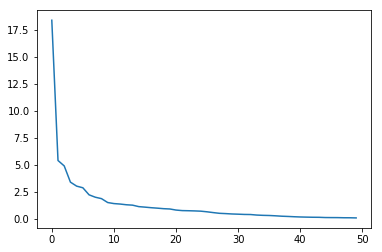

In [90]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
dfpca = pca.fit(X_nocorr) 
pca_dim_exp = dfpca.explained_variance_
print(pca_dim_exp)
plt.plot(pca_dim_exp)


## Based on the elbow criteria we test the model using only the first 3 principal components 

In [91]:
pca = PCA(n_components=3)
dfpca = pca.fit(X_nocorr) 
X_pca = pca.transform(X_nocorr)

In [92]:
scores = cross_val_score(rfclf, X_pca, y, cv=4,n_jobs=-1,verbose =1)
print(scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  1.9min remaining:  1.9min


0.816643832212306


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.9min finished


## Accuracy diminished completely (worse than majority ratio of 0.19)  so we will not implement this technic

In [93]:
y.mean()

ind    0.178224
dtype: float64

# Analyzing feature importance

In [99]:
from sklearn.ensemble import RandomForestClassifier
rfclf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
rfclf.fit(X_nocorr, y)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [98]:
X_nocorr = correlated_features(X,.95)

Dropped columns with 0.95 correlation with another column:['tot_paid', 'ct_pmt', 'ct_pln_ovr30', 'plan_list_price_max', 'plan_list_price_min', 'plan_list_price_mean', 'plan_list_price_std', 'actual_amount_paid_max', 'actual_amount_paid_min', 'actual_amount_paid_mean', 'actual_amount_paid_std', 'actual_amount_paid_cnt', 'auto_renew_cnt', 'last_plan_price', 'last_paid', 'days_since_reg', 'sum_75', 'sum_985', 'min_seconds', 'std_seconds']


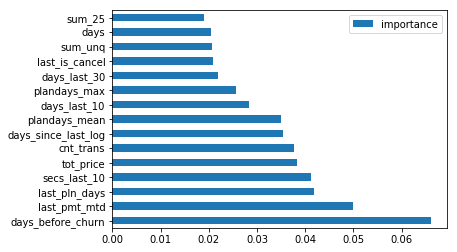

In [100]:
feature_importances = pd.DataFrame(rfclf.feature_importances_,index = X_nocorr.columns,columns=['importance']).sort_values('importance',ascending=False)
feature_importances.iloc[:15].plot(kind='barh')

In [101]:
feature_importances

,importance
days_before_churn,0.066137
last_pmt_mtd,0.049956
last_pln_days,0.041782
secs_last_10,0.041284
tot_price,0.038358
cnt_trans,0.037755
days_since_last_log,0.035397
plandays_mean,0.035057
days_last_10,0.028270
plandays_max,0.025647


## Reduce dimensions using backward elimination based on variable importance
We will achieve this by running the classifier each time with other variable reduced.

In [52]:
def feature_reduction_impact(X_red,y_red):
    i = 0
    l = len(list(X_red))-1
    rfclf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
    X_scores = pd.DataFrame(columns = ['var','importance','score','std'])

    while i<l:
        rfclf.fit(X_red,y_red)
        importance= pd.DataFrame(rfclf.feature_importances_, index=X_red.columns,columns=['importance']).sort_values('importance',ascending=True)
        importance.reset_index(inplace= True)
        to_drop = importance.iloc[0,:]
        X_red = X_red.drop(to_drop[0],axis=1)
        scores = cross_val_score(rfclf,X_red,y_red,cv=5,n_jobs=-1,verbose=1)
        X_scores.loc[i] = [to_drop[0]]+ [to_drop[1]] + [scores.mean()] +[scores.std()]
        i+=1
        print(to_drop)
    return X_scores

##### Note: The following code might take 5-6 hours on a good PC

In [102]:
var_red = pd.DataFrame()
var_red = feature_reduction_impact(X_nocorr,y)
var_red.reset_index(inplace=True)    

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.3min finished


index             min_985
importance    0.000141377
Name: 0, dtype: object


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.1min finished


index              min_75
importance    0.000133031
Name: 0, dtype: object


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.1min finished


index              min_50
importance    0.000219608
Name: 0, dtype: object


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.5min finished


index              min_25
importance    0.000599925
Name: 0, dtype: object


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.6min finished


index         registered_via_4
importance          0.00143887
Name: 0, dtype: object


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.6min finished


index         registered_via_3
importance          0.00193387
Name: 0, dtype: object


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.3min finished


index         gender_female
importance       0.00191793
Name: 0, dtype: object


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.9min finished


index             city_B
importance    0.00201332
Name: 0, dtype: object


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.3min finished


index            min_unq
importance    0.00197727
Name: 0, dtype: object


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.9min finished


index         gender_male
importance     0.00215416
Name: 0, dtype: object


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.0min finished


index            min_100
importance    0.00212835
Name: 0, dtype: object


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min finished


index             city_C
importance    0.00229211
Name: 0, dtype: object


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min finished


index         registered_via_9
importance          0.00254817
Name: 0, dtype: object


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.8min finished


index           pln_uniq
importance    0.00292556
Name: 0, dtype: object


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min finished


index             city_A
importance    0.00416759
Name: 0, dtype: object


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min finished


index             max_75
importance    0.00316747
Name: 0, dtype: object


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.4min finished


index         pmt_method_num
importance        0.00427741
Name: 0, dtype: object


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.0min finished


index           ct_pln30
importance    0.00557244
Name: 0, dtype: object


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.6min finished


index         num_cancel
importance     0.0062461
Name: 0, dtype: object


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.3min finished


index         registered_via_7
importance          0.00522348
Name: 0, dtype: object


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.6min finished


index         times_churn
importance     0.00741421
Name: 0, dtype: object


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.9min finished


index           max_985
importance    0.0074349
Name: 0, dtype: object


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.9min finished


index             max_50
importance    0.00750403
Name: 0, dtype: object


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.5min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index         last_trans_weekday
importance             0.0115412
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.3min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index         plandays_min
importance       0.0115233
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min finished


index               bd
importance    0.012929
Name: 0, dtype: object


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.0min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index           max_100
importance    0.0133059
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.3min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index           max_25
importance    0.013604
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.4min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index         plandays_std
importance       0.0136658
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.3min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index         cnt_autorenew
importance        0.0125853
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index           max_unq
importance    0.0155115
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.4min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index          mean_100
importance    0.0159204
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.3min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index         mean_25
importance     0.0174
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.0min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index         can_ratio
importance    0.0167243
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index          mean_985
importance    0.0181763
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index            sum_50
importance    0.0192273
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.0min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index         last_auto_renew
importance          0.0178561
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index           std_100
importance    0.0202267
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.2min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index         days_last_10
importance         0.01739
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.6min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index           sum_100
importance    0.0206592
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.1min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index            std_75
importance    0.0222807
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.0min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index           mean_50
importance    0.0239302
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.6min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index         plandays_max
importance       0.0196851
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index            sum_25
importance    0.0255057
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index          mean_unq
importance    0.0266623
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index           std_985
importance    0.0284392
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.5min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index         last_is_cancel
importance         0.0307719
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index         mean_seconds
importance       0.0320151
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.5min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index            std_50
importance    0.0343499
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index           std_25
importance    0.037371
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index         max_seconds
importance       0.041616
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index         tot_price
importance    0.0375728
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index         days_last_30
importance       0.0376233
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index          std_unq
importance    0.049544
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index           mean_75
importance    0.0559193
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index         last_pln_days
importance        0.0626624
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index           sum_unq
importance    0.0671588
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index         days_logged
importance      0.0681576
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index         cnt_trans
importance    0.0719634
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index         days_since_last_log
importance              0.0683928
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index              days
importance    0.0940281
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index         secs_last_10
importance        0.115565
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index         last_pmt_mtd
importance        0.145565
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index         days_first_last_trans
importance                 0.166094
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index         days_before_churn
importance             0.185869
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


index         plandays_mean
importance         0.251465
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


index         secs_last_30
importance         0.47169
Name: 0, dtype: object


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min finished


The following plot shows Variable Index / Random Forest Socre, we can see that only small number of variables do change the output score.

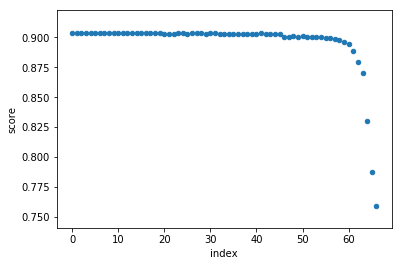

In [103]:
var_red.plot(kind='scatter',x = 'index',  y='score')

In [105]:
print(var_red.iloc[1:50,:])

    index                 var  importance     score       std
1       1              min_75    0.000133  0.903898  0.021996
2       2              min_50    0.000220  0.903997  0.022196
3       3              min_25    0.000600  0.903883  0.021789
4       4    registered_via_4    0.001439  0.903874  0.021881
5       5    registered_via_3    0.001934  0.903638  0.022393
6       6       gender_female    0.001918  0.903982  0.021760
7       7              city_B    0.002013  0.903529  0.021802
8       8             min_unq    0.001977  0.904017  0.021766
9       9         gender_male    0.002154  0.903968  0.021821
10     10             min_100    0.002128  0.904093  0.021797
11     11              city_C    0.002292  0.903938  0.022142
12     12    registered_via_9    0.002548  0.903747  0.022257
13     13            pln_uniq    0.002926  0.903977  0.021866
14     14              city_A    0.004168  0.903765  0.022217
15     15              max_75    0.003167  0.903491  0.022210
16     1

### We can learn from the table and chart that by eliminating the first 46 lowest important variables
### Accuracy will drop from 0.8923 to 0.8900., but at the same time we will reduce the number of features by 2/3.
##### Side note: the accuracy with all noncorrelated features was 0.897 but this seems like a too optimistic result as 
#### we can learn from the table that removing 1 least significant variable shouldn't have made a drop from 0.897 to 0.892

### Thus we shall remove the least important 46 variables and test results again

In [107]:
drop_lis = ['min_985','min_50','min_25','registered_via_4','city_B','registered_via_3','gender_female','min_unq',
            'gender_male','min_100','city_C','registered_via_9','pln_uniq','max_75','city_A','pmt_method_num',
            'ct_pln30','plandays_min','times_churn','max_50','max_985','registered_via_7','num_cancel',
            'last_trans_weekday','max_100','max_25','bd','last_auto_renew','mean_100','max_unq',
            'plandays_std','mean_25','mean_985','mean_50','std_100','last_is_cancel','sum_100','cnt_autorenew','std_75','std_985','days_logged','sum_50','plandays_max','days_last_30','std_25']
X_stepwise = X_nocorr.drop(drop_lis,axis=1)

#### We shall run cross validation again to see how dimension reduction have helped maintaining high accuracy.

In [108]:
scores = cross_val_score(rfclf, X_stepwise, y, cv=4,n_jobs=-1,verbose =2)
print(scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.8970125266415306


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.7min finished


In [109]:
print(scores.std())

0.025450267883414927


### Attempt to calibrate model using grid search:
We would like to see if it is possible to achieve better accuracy while optimzing the model's hyper-parameters.

In [111]:
from sklearn.model_selection import GridSearchCV
random_grid = {'n_estimators': [50],
               'max_features': ['log2'],
               'max_depth': [6],
               'min_samples_split': [2,3],
               'min_samples_leaf': [4,6,8],
              'criterion' :['gini']}
grid_rfc = GridSearchCV(estimator=rfc, param_grid=random_grid, cv= 2)
grid_rfc.fit(X_stepwise, y)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50], 'max_features': ['log2'], 'max_depth': [6], 'min_samples_split': [2, 3], 'min_samples_leaf': [4, 6, 8], 'criterion': ['gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [112]:
grid_rfc.best_estimator_
#min_Sample_Split = 2 (optimized)
#min_Samples_leaf = 6 (optimized)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [113]:
# run optimized classifier based on grid search
clf_optimized = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

scores = cross_val_score(clf_optimized, X_stepwise, y, cv=4,n_jobs=-1,verbose =1)
print ('Mean Cross validation score: ' +str(scores.mean()))
print ('STD Cross validation score: ' +str(scores.std()))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   54.6s remaining:   54.6s


Mean Cross validation score: 0.8803712374236278
STD Cross validation score: 0.025984111590276363


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   55.3s finished


#### Conclusion: Gridsearch optimization didn't improve accuracy of the model, hence we will proceed to the evaluation phase with the basic random forest classifier

# Step 5: Model Evaluation on validation set
In this step we will upload the out of test set data (cutoff date = 28.1.2017) and use our optimized classifier (RandomForest, trained on trimmed data and usnig the hyperparameters from the gridsearch) vs non_optimzed classifier (RandomForest, all the variables, basic hyperparameters). 

In [173]:
X_validation = pd.read_pickle('X'+validations_timestamps[0]+'.pickle')
y_validation = pd.read_pickle('y'+validations_timestamps[0]+'.pickle')

In [174]:
#Modifying X per our step 4 of dimension reduction.
X_validation.drop(drop_lis,axis=1,inplace = True)
X_validation = X_validation.drop(['join_date','last_exp_date','last_logged','last_trans_date'],axis=1) #removing date variable
X_validation.drop(['tot_paid', 'ct_pmt', 'ct_pln_ovr30', 'plan_list_price_max', 'plan_list_price_min', 
                   'plan_list_price_mean', 'plan_list_price_std', 'actual_amount_paid_max', 'actual_amount_paid_min', 
                   'actual_amount_paid_mean', 'actual_amount_paid_std', 'actual_amount_paid_cnt', 'auto_renew_cnt', 
                   'last_plan_price', 'last_paid', 'days_since_reg', 'sum_75', 
                   'min_seconds', 'std_seconds','sum_985'],axis=1,inplace = True)


In [176]:
X_validation

,days,cnt_trans,tot_price,can_ratio,plandays_mean,last_pmt_mtd,last_pln_days,days_first_last_trans,days_before_churn,days_since_last_log,...,mean_75,mean_unq,mean_seconds,max_seconds,min_75,std_50,std_unq,days_last_10,secs_last_30,secs_last_10
msno,,,,,,,,,,,,,,,,,,,,,
+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,410.0,1,1788,0.000000,410.000000,38,410,1062.0,7,1.0,...,0.329268,83.461672,22923.781003,40703.487,0.0,0.723306,48.883568,8.0,280232.411,22222.691
++7jYuHyUSp41PyuttFx/MCepv7TdFQULgN8TxZULZk=,707.0,25,3725,0.040000,30.160000,40,30,4174.0,19,212.0,...,0.448087,12.295082,2515.615770,13455.131,0.0,0.927990,12.501882,0.0,0.000,0.000
++92FghbCQPqDmQ96QzNiuEMoDxrMOmuaisu1UCrYn0=,361.0,14,2086,0.071429,30.000000,23,30,361.0,17,6.0,...,0.442446,37.949640,9633.020989,34819.487,0.0,0.873777,28.242969,1.0,74604.244,179.583
++9l7+WGOZ96gNp0TDXxHAydOlXYE0CiuqWFTxA6zZI=,410.0,1,1788,0.000000,410.000000,38,410,1585.0,8,6.0,...,0.725397,20.928571,5224.533425,32478.586,0.0,2.027195,20.339245,1.0,35585.641,307.165
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,210.0,7,1043,0.000000,30.000000,38,30,378.0,4,29.0,...,0.470588,15.858824,2474.943494,12728.417,0.0,1.118097,14.459428,0.0,2716.087,0.000
++CzVs35NSfU/gjDrGbWLVMweubEiMZsuvd3eTbXs58=,485.0,18,2632,0.055556,30.000000,41,30,485.0,14,1.0,...,1.103982,7.371681,6383.988836,28470.869,0.0,1.977425,10.982304,6.0,102569.712,26174.635
++EX7OEtJz+hvd7VXRkcZINs+guDwpHq7ahe/o99E1o=,207.0,7,1043,0.000000,30.000000,37,30,202.0,30,1.0,...,1.136364,29.827273,7371.648345,42037.806,0.0,2.298493,27.900498,3.0,44695.873,10787.381
++FNH/2Fg+6/Q+61X5t3PTVvNsFC699bnEVaVN6HT+o=,157.0,6,596,0.000000,21.166667,38,7,4159.0,6,27.0,...,0.750000,9.968750,1998.116250,6510.618,0.0,1.635974,8.767552,0.0,5382.804,0.000
++L3Kr4/CtPSdU9BrsaX/E9ziEKoD9yK5vwk8DVXmHo=,552.0,20,2086,0.050000,21.000000,38,30,1858.0,13,18.0,...,0.784211,51.594737,14103.732151,63790.189,0.0,2.062195,46.474389,0.0,160227.013,0.000


In [177]:
rfclf_stepwise = RandomForestClassifier(n_estimators=50, n_jobs=-1)
rfclf_stepwise.fit(X_stepwise, y)

y_validation_pred = rfclf_stepwise.predict(X_validation)
cm = sk.metrics.confusion_matrix(y_validation,y_validation_pred)/len(y_validation)
print (cm)
print((cm[0,0]  +cm[1,1]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


[[0.6851344  0.06000828]
 [0.10160919 0.15324813]]
0.8383825317569141


We can spot a drop in Accuracy from 0.89 to 0.838. The drop is in part due to the out out of sample data, seasonality (we've noticed the presese of seasonality as churn rates vary significantly between  months) and the fact that the churn rate in the validation data is 0.25 compared to 0.19 in the training set. A higher churn rate should reflect lower accuracy.

In order to understand the impact our optimization procedures had we shall run simple RF classifier, this time with the original hyper parameters and all the variables.


In [178]:
X_validation = pd.read_pickle('X'+validations_timestamps[0]+'.pickle')
y_validation = pd.read_pickle('y'+validations_timestamps[0]+'.pickle')
X_validation = X_validation.drop(['join_date','last_exp_date','last_logged','last_trans_date'],axis=1) #removing date variable

rfclf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
rfclf.fit(X, y)

y_validation_pred = rfclf.predict(X_validation)
cm = sk.metrics.confusion_matrix(y_validation,y_validation_pred)/len(y_validation)
print (cm)
print((cm[0,0]  +cm[1,1]))



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


[[0.69446097 0.05068171]
 [0.09906087 0.15579645]]
0.8502574185703567


## Results:
Confusion Matrix:
### [[0.69446097 0.05068171]
### [0.09906087 0.15579645]]

Accuracy: 0.850

From the results we can learn that the original classifier was actually better than the optimized one. 
Accuracy 0.850, higher by 0.012 compared to optimized. Apparently it didn't suffer from overfitting and going forward we will use the naive classifer to present the business case


## We will make one more attempt to improve the results by balancing the data through oversampling

In [181]:
#Oversampling (using the original dataset)
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X, y.values.ravel())

#Analyzing performance
rfclf_os = RandomForestClassifier(n_estimators=50, n_jobs=-1)
rfclf_os.fit(X_resampled, y_resampled.ravel())

y_validation_pred = rfclf_os.predict(X_validation)
cm = sk.metrics.confusion_matrix(y_validation,y_validation_pred)/len(y_validation)
print (cm)
print((cm[0,0]  +cm[1,1]))


[[0.67767056 0.06747212]
 [0.0861382  0.16871912]]
0.84638967221173


### as expected oversampling managed to improve the rate of TP (by ~0.014) but at the expense of higher FP (by ~0.017)
### Accuracy dropped by a bit to 0.846, still better than the "optimized" model (0.838)
### Since Oversampling altered the model results in a significant way, we will evaluate it again in the business case where actual profits are the end goal. 

# Step 6: Presenting a business case scenario

The company will try to maximize profits by offering 10 USD discount for renewed subscription. So instead of 20 USD the renewal will cost 10 USD

The company will gain 10 USD for each user it manages to "rescue" from churning.(such user will pay 10 USD instead of none)
It will lose 10 USD for each user that intended to renew anyway. (such user will pay 10 USD instead of 20 USD)

Premise:
    1. 50% of churned users will decide to renew given the discounted price



    

We will sort the users by their predicted churn score and demonstrate how this can be used in a real business environment 

In [182]:
temp = pd.DataFrame()
rfclf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
rfclf.fit(X, y)
temp['actual'] = y_validation.reset_index().iloc[:,1]
temp['score'] = rfclf.predict_proba(X_validation)[:,1]
temp = temp.sort_values('score',ascending=False)
temp = temp.reset_index()
percentile = math.trunc(len(temp)/100)
performance = pd.DataFrame()
a = 0 # count rows in each percentile
b=0 #sum of churners
c= 0 # number of pecenntile
d = 0
for i in range (len(temp)):
    if a<percentile:
        a+=1
        b+=temp.actual[i]
    else:
        performance = pd.concat([performance,pd.DataFrame([c,b,percentile-b]).T])
        print('percentile '+str(c) +'% of actual churners ='+ str(b/percentile) + 'Actual Churners '+str(b)
       +'Non Churners:'+str(percentile - b))
        a=0
        b=0
        c+=1

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


percentile 0% of actual churners =0.9974126778783958Actual Churners 771Non Churners:2
percentile 1% of actual churners =0.9922380336351876Actual Churners 767Non Churners:6
percentile 2% of actual churners =0.9883570504527813Actual Churners 764Non Churners:9
percentile 3% of actual churners =0.9741267787839586Actual Churners 753Non Churners:20
percentile 4% of actual churners =0.9728331177231565Actual Churners 752Non Churners:21
percentile 5% of actual churners =0.9353169469598965Actual Churners 723Non Churners:50
percentile 6% of actual churners =0.9301423027166882Actual Churners 719Non Churners:54
percentile 7% of actual churners =0.908150064683053Actual Churners 702Non Churners:71
percentile 8% of actual churners =0.8576972833117723Actual Churners 663Non Churners:110
percentile 9% of actual churners =0.7930142302716688Actual Churners 613Non Churners:160
percentile 10% of actual churners =0.7710219922380336Actual Churners 596Non Churners:177
percentile 11% of actual churners =0.712807

percentile 96% of actual churners =0.01164294954721863Actual Churners 9Non Churners:764
percentile 97% of actual churners =0.009055627425614488Actual Churners 7Non Churners:766
percentile 98% of actual churners =0.015523932729624839Actual Churners 12Non Churners:761


In [183]:
performance.columns = ['percentile', 'actual_churners', 'actual_nonchurners']
a = 0
b=0
performance['accumulated_churners'] = 0
performance['accumulated_non_churners'] = 0

for i in range(len(performance)):
    a = a+performance.iloc[i,1]
    b=b+performance.iloc[i,2]
    performance.iloc[i,3] = a
    performance.iloc[i,4] = b


In [184]:
# Calculating the profit by percentile

In [185]:
performance['profit'] = performance['accumulated_churners']*10*0.5 - performance['accumulated_non_churners']*10

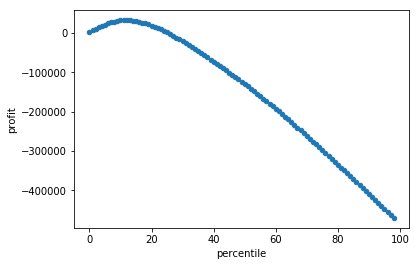

In [186]:
performance.plot.scatter(x = 'percentile', y = 'profit')

In [187]:
performance

,percentile,actual_churners,actual_nonchurners,accumulated_churners,accumulated_non_churners,profit
0,0,771,2,771,2,3835.0
0,1,767,6,1538,8,7610.0
0,2,764,9,2302,17,11340.0
0,3,753,20,3055,37,14905.0
0,4,752,21,3807,58,18455.0
0,5,723,50,4530,108,21570.0
0,6,719,54,5249,162,24625.0
0,7,702,71,5951,233,27425.0
0,8,663,110,6614,343,29640.0
0,9,613,160,7227,503,31105.0


## From the table and chart we can see that profitability peaks at the 11th percentile where the company "rescues" 8,910 users and misclassify 1,139 users.
## The monthly profit of this marketing activity using this cutoff point is $32,850.0

We can also see that without the prediction model this marketing activity is not feasible. If it was sent to all users who are up for renewal the company would have lost $470,220.

# Conclusions and Improvements: 
- This was a very challenging project, we enjoyed every bit of making it. we hope it become useful and fruitful for the ready.
- We've managed to create a model using Random Forest that predicts succesfully around 85% of churners.
    Which could lead into a profit of roughly $33,000.
- Dimension reduction using backward elimination was great, we have made a great size loss for the feature vector without reducing accuracy that much.    
- Dimension reduction using PCA was bad.   
- Grid Search and Oversampling the data didn't help acheiving a better model.    
- Model Stacking (Placing one learning model prediciton into another learning model variables) might have improved the accuracy.
